<a href="https://colab.research.google.com/github/thalisrocha/Active-contour/blob/main/TP_Active_Contours_ROCHA_PESTANA_Thalis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries and Functions

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML
from matplotlib import animation, rc

from skimage.color import rgb2gray
from skimage import data
from skimage.filters import gaussian
from skimage.segmentation import active_contour # For active_contour function

# For active_contour function
from skimage.segmentation import chan_vese, morphological_chan_vese, checkerboard_level_set,morphological_geodesic_active_contour

# For some image filtering
from skimage.morphology import white_tophat, black_tophat, disk

import skimage.io

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"



In [ ]:
def edge_map(img,sigma):
    blur = skimage.filters.gaussian(img,sigma)
    return skimage.filters.sobel(blur)

def edge_map2(img,sigma):
    blur = skimage.filters.gaussian(img,sigma)
    return skimage.filters.scharr(blur)

def subtract_background(image, radius=5, light_bg=False):
        str_el = disk(radius)
        if light_bg:
            return black_tophat(image, str_el)
        else:
            return white_tophat(image, str_el)


def define_initial_circle(R0,r0,c0,Nber_pts=400):
    # Define initial contour shape
    s      = np.linspace(0, 2*np.pi, Nber_pts)
    Radius = R0
    r      = r0 + Radius*np.sin(s)
    c      = c0 + Radius*np.cos(s) #col
    init   = np.array([r, c]).T
    return init


## Create slides for animation
def animate_cv(image, segs, interval=1000):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(image, cmap='gray');
    im = ax.imshow(segs[0], alpha=0.5, cmap='inferno');
    ax.axis('off')

    def init():
        im.set_data(segs[0])
        return [im]

    def animate(i):
        im.set_array(segs[i])
        return [im]

    anim = animation.FuncAnimation(fig, animate, init_func=init,
                                   frames=len(segs), interval=1000, blit=True);
    return anim


def animate_snake(image, segs, interval=500):
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.imshow(image, cmap='gray');
    # im = ax.imshow(segs[0], alpha=0.5, cmap='inferno');
    # ax.plot(segs[0][:, 1], segs[0][:, 0], '--r', lw=3)
    ax.axis('off')
    line, = ax.plot([], [], '-r', lw=2)

    def init():
        line.set_data(segs[0,:,1],segs[0,:,0])
        return [line,]

    def animate(i):
        line.set_data(segs[i,:,1],segs[i,:,0])
        return [line,]

    anim = animation.FuncAnimation(fig, animate, init_func=init,
                                   frames=len(segs), interval=1000, blit=True);
    return anim



###########################
def store_evolution_in(lst):
    """Returns a callback function to store the evolution of the level sets in
    the given list.
    """

    def _store(x):
        lst.append(np.copy(x))

    return _store

# Read images

This cell reads a series of images that you can then use in various tests. <br>
Note that some images are provided with ground-truth masks of structures of interest:<br>
1. OCT_myocardium/case272.tif [one image]
2. images_blood_cells/000016.png [several images available]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

path = "/content/drive/MyDrive/IMA"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


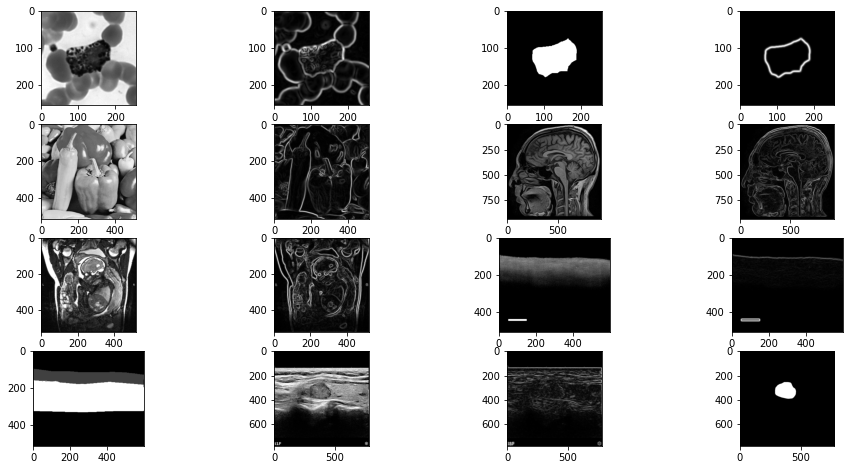

In [ ]:
# import warnings
# warnings.filterwarnings( "ignore", module = "matplotlib\..*" )

img_star          = skimage.io.imread(path+'/images_misc/smooth_star.png', as_gray = True)
img_star_noisy    = skimage.io.imread(path+'/images_misc/smooth_star_noisy.png', as_gray = True)

img_hela    = skimage.io.imread(path+'/images_misc/hela_big_gt.png', as_gray = True)
edge_hela   = edge_map(img_hela, sigma=2)

img_pepper  = skimage.io.imread(path+'/images_misc/peppers_gt.png', as_gray = True)
edge_pepper = edge_map(img_pepper, sigma=2)
img_pepper  = img_pepper.astype('float64')

img_MRIb  = skimage.io.imread(path+'/images_misc/MRI_brain_sag.png', as_gray = True)
edge_MRIb = edge_map(img_MRIb, sigma=2)
img_MRIf  = skimage.io.imread(path+'/images_misc/MRI_fetus.png', as_gray = True)
edge_MRIf = edge_map(img_MRIf, sigma=2)


img_cell  = skimage.io.imread(path+'/images_blood_cells/000016.png', as_gray = True)
edge_cell = edge_map(img_cell, sigma=2)
#skimage.io.imshow(img_cell)

img_mask = skimage.io.imread(path+'/masks_blood_cells/000016.png', as_gray = True)
edge_mask = edge_map(img_mask, sigma=2)
# skimage.io.imshow(img_mask)

img_OCT  = skimage.io.imread(path+'/OCT_myocardium/case272.tif', as_gray = True)
edge_OCT = edge_map(img_OCT, sigma=2)
labels_OCT = skimage.io.imread(path+'/OCT_myocardium/case272_label.tiff', as_gray = True)


img_nodule = skimage.io.imread(path+'/thyroid_nodule/1074.png', as_gray = True)
edge_nodule = edge_map(img_nodule, sigma=2)
labels_nodule = skimage.io.imread(path+'/thyroid_nodule/1074_mask.png', as_gray = True)


fig, axes = plt.subplots(4,4, figsize=(16, 8))
ax = axes.ravel()
ax[0].imshow(img_cell, cmap=plt.cm.gray);
ax[1].imshow(edge_cell, cmap=plt.cm.gray);
ax[2].imshow(img_mask, cmap=plt.cm.gray);
ax[3].imshow(edge_mask, cmap=plt.cm.gray);
ax[4].imshow(img_pepper, cmap=plt.cm.gray);
ax[5].imshow(edge_pepper, cmap=plt.cm.gray);
ax[6].imshow(img_MRIb, cmap=plt.cm.gray);
ax[7].imshow(edge_MRIb, cmap=plt.cm.gray);
ax[8].imshow(img_MRIf, cmap=plt.cm.gray);
ax[9].imshow(edge_MRIf, cmap=plt.cm.gray);
ax[10].imshow(img_OCT, cmap=plt.cm.gray);
ax[11].imshow(edge_OCT, cmap=plt.cm.gray);
ax[12].imshow(labels_OCT, cmap=plt.cm.gray);
ax[13].imshow(img_nodule, cmap=plt.cm.gray);
ax[14].imshow(edge_nodule, cmap=plt.cm.gray);
ax[15].imshow(labels_nodule, cmap=plt.cm.gray);

# Image properties:
## Range of values and data type matter ...


Some routines won't work if your image type is int8 or uint8...
Here is how to check your image data type

And regularly check your image content in terms of:
* intensities range of values
* distributions of intensities via its histogram


float64
0.04579333333333333
255.0


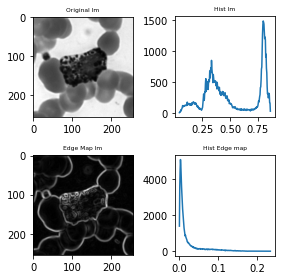

In [ ]:

img_test  = img_cell
Sigma_val = 1
edge_test = edge_map(img_test, sigma=Sigma_val)


## Print some basic image properties
print(img_test.dtype)
print(np.min(img_test))
print(np.max(img_pepper))


## Show Hist
hist_test, bins_test             = np.histogram(img_test.flatten(), bins=256)
hist_edge_test, bins_edges_test  = np.histogram(edge_test.flatten(), bins=256)

fig, axes = plt.subplots(2,2, figsize=(4, 4))
ax        = axes.ravel()
ax[0].imshow(img_test, cmap=plt.cm.gray);
ax[0].set_title("Original Im", fontsize=6);
ax[1].plot(bins_test[0:-1],hist_test);
ax[1].set_title("Hist Im", fontsize=6);
ax[2].imshow(edge_test, cmap=plt.cm.gray);
ax[2].set_title("Edge Map Im", fontsize=6);
ax[3].plot(bins_edges_test[0:-1],hist_edge_test);
ax[3].set_title("Hist Edge map", fontsize=6);
fig.tight_layout()
plt.show();



# Edge maps
Deformable models rely on edge maps. Most routines have their own strategy coded to compute the edge map.

* Edge maps usually involve smoothing of the image, to be robust to noise. Make sure you understand how this is controlled in the routine you use.
* Edge maps usually show pixels with high gradient magnitudes in white (high values)
* Most deformable model routines can be fed directly with an Edge Map rather than the original image as its input
* Some routine expect to be fed with an inverse edge map where high gradient locations have small values, to stop the contour via a velocity set to ~zero.

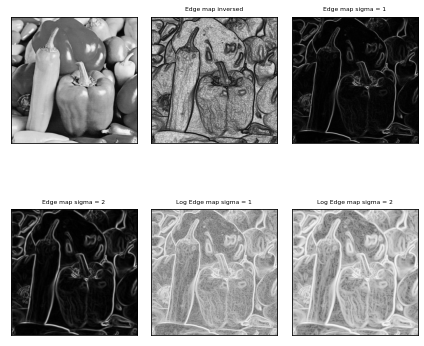

In [ ]:

img_to_test = img_pepper

# Classic Edge map with Gaussian smoothing controled by sigma
edge_test1         = edge_map(img_to_test, sigma=1)
edge_test1_l       = np.log2(edge_test1)
edge_test2         = edge_map(img_to_test, sigma=2)
edge_test2_l       = np.log2(edge_test2)

# Inversed Edge map
# Returns Edge map = 1.0 / np.sqrt(1.0 + alpha * gradnorm)
edge_inv_test  = skimage.segmentation.inverse_gaussian_gradient(img_to_test, alpha=1.0, sigma=1.0)


fig, axes = plt.subplots(2,3, figsize=(6, 6))
ax = axes.ravel()

ax[0].imshow(img_to_test, cmap=plt.cm.gray);
ax[1].imshow(edge_inv_test, cmap=plt.cm.gray);
ax[1].set_title("Edge map inversed", fontsize=6);
ax[2].imshow(edge_test1, cmap=plt.cm.gray);
ax[2].set_title("Edge map sigma = 1", fontsize=6);
ax[3].imshow(edge_test2, cmap=plt.cm.gray);
ax[3].set_title("Edge map sigma = 2", fontsize=6);
ax[4].imshow(edge_test1_l, cmap=plt.cm.gray);
ax[4].set_title("Log Edge map sigma = 1", fontsize=6);
ax[5].imshow(edge_test2_l, cmap=plt.cm.gray);
ax[5].set_title("Log Edge map sigma = 2", fontsize=6);

for i in range(0,6):
    ax[i].set_xticks([]), ax[i].set_yticks([]);

fig.tight_layout()
plt.show();

# Test some image manipulations

Let you test some image transformations based on morphological operators and histogram manipulation.
When transforming image contrast, it is always interesting to look at the differences between the original image and the transformed version.

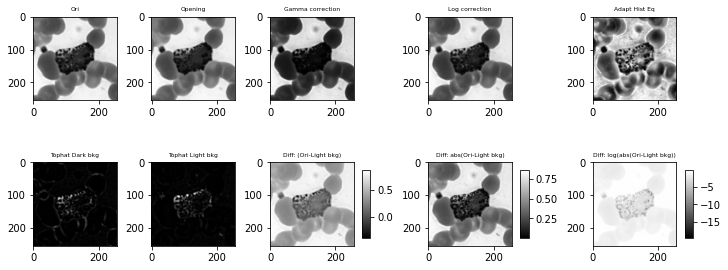

In [ ]:
img_ori_to_test = img_cell
img_to_test     = img_ori_to_test

PRE_ENHANCE     = 1
OPTION_ENHANCE  = 0 # can be 0 (nothing) to 4

# Run all  OPTION_ENHANCE for display here
gamma_corrected       = skimage.exposure.adjust_gamma(img_to_test, 2)
logarithmic_corrected = skimage.exposure.adjust_log(img_to_test, gain= 1,inv=True)
img_open              = skimage.morphology.diameter_opening(img_to_test, 40, connectivity=2)
img_adapteq           = skimage.exposure.equalize_adapthist(img_to_test, clip_limit=0.03)

# PRE ENHANCEMENT OPTIONS:
if PRE_ENHANCE==1:
    if OPTION_ENHANCE==1:
        # Gamma
        img_to_test     = gamma_corrected
    elif OPTION_ENHANCE==2:
        # Logarithmic (O = gain*log(1 + I)) or if Inv (O = gain*(2**I - 1))
        img_to_test           = logarithmic_corrected
    elif OPTION_ENHANCE==3:
        # Morpho Opening
        img_to_test           = img_open
elif OPTION_ENHANCE==4:
        # Contrast Limited Adaptive Histogram Equalization (CLAHE).
        img_to_test           = img_adapteq

# Enhance details either dark around light background of vice versa with the Top-Hat transform
Radius_val = 5
img_test1  = subtract_background(img_to_test, radius=Radius_val, light_bg=False)
img_test2  = subtract_background(img_to_test, radius=Radius_val, light_bg=True)

# SHOW OUTPUTS
fig, axes = plt.subplots(2,5, figsize=(10, 4),constrained_layout=True)
ax        = axes.ravel()
Shrink_factor_colormap = 0.5
ax[0].imshow(img_ori_to_test, cmap=plt.cm.gray);
ax[0].set_title("Ori", fontsize=6);

ax[1].imshow(img_open, cmap=plt.cm.gray);
ax[1].set_title("Opening", fontsize=6);
ax[2].imshow(gamma_corrected, cmap=plt.cm.gray);
ax[2].set_title("Gamma correction", fontsize=6);
ax[3].imshow(logarithmic_corrected, cmap=plt.cm.gray);
ax[3].set_title("Log correction", fontsize=6);
ax[4].imshow(img_adapteq, cmap=plt.cm.gray);
ax[4].set_title("Adapt Hist Eq", fontsize=6);

ax[5].imshow(img_test1, cmap=plt.cm.gray);
ax[5].set_title("Tophat Dark bkg", fontsize=6);
ax[6].imshow(img_test2, cmap=plt.cm.gray);
ax[6].set_title("Tophat Light bkg", fontsize=6);

tmp_show = ax[7].imshow(img_to_test-img_test2, cmap=plt.cm.gray);
ax[7].set_title("Diff: (Ori-Light bkg)", fontsize=6);
plt.colorbar(tmp_show,ax=ax[7], shrink=Shrink_factor_colormap, location='right')

tmp_show = ax[8].imshow(abs(img_to_test-img_test2), cmap=plt.cm.gray);
ax[8].set_title("Diff: abs(Ori-Light bkg)", fontsize=6);
plt.colorbar(tmp_show,ax=ax[8], shrink=Shrink_factor_colormap, location='right')

tmp_show = ax[9].imshow(np.log2(abs(img_to_test-img_test2)), cmap=plt.cm.gray);
ax[9].set_title("Diff: log(abs(Ori-Light bkg))", fontsize=6);
plt.colorbar(tmp_show,ax=ax[9], shrink=Shrink_factor_colormap, location='right')

#fig.tight_layout() # not compatible with option constrained_layout=True in plt.subplots needed to display the colorbar
plt.show();


# Seg #1:
### Snake on a binary shape

Based on the routine **active_contour** from skimage. <br>
Default **parameter values** are: <br>
* alpha=0.01  (Snake length shape parameter. Higher values makes snake contract faster.)
* beta=0.1    (Snake smoothness shape parameter. Higher values makes snake smoother.)
* gamma=0.01  (Explicit time stepping parameter - Equivalent to the viscosity of the environment)
* max_px_move=1.0
<br>

There are two **other parameters** that define the final image information used to define external forces used to define regions.img = w_line x img + w_edge x edge: <br>
*   w_line_val= 0 (default) | =1 if want to input_edge map directly. Use negative values to attract toward dark
*   w_edge_val= 1 (default)  | = 0 if do not want to use internal edge map. Use negative values to repel snake from edges


## TODO:
1. Run the cell for **img_to_seg=img_mask** with the sets of parameter values provided. 1st set uses values by default, 2nd-3rd sets use custom values to help improve the smoothness of the final contour. <br>
    1. Comment on defaults seen on the obtained initial segmentations. <br>
    1. Explain why you think increasing the gamma_val has better helped smooth the final contour.  <br>

2. Test now by using a small initial circle inside the white shape. What is happening and what additional force seen in the class could help fixing this issue?

3. Now run the segmentation on the **img_to_seg=img_star** or **img_to_seg=img_star_noisy**. Try the same parameter values adjustments as before to get a smoother final contour. Comment on the issues observed with the two options.
4. BONUS: there is a way to obtain a "perfect" segmentation for the star shape. Propose one solution which might involve many more iterations, once you have checked with few iterations that behavior is stable.


1.
  
  1.1. It is possible to verify some oscillations in the contours obtained with the default parameters.

  1.2. Gamma is equivalent to the viscosity. Increasing the gamma implies in a reduction in the velocity in which the edges of the image are reached. If gamma is well adjusted the forces have more time to act in the edges and we have an improvement in precision. However, if gamma is too big, the viscosity augments and the forces can not act in the edges properlly.

2. Applying a circle with small radius the initialization is not good. It means that the contour is too far from the edges of the object and the blurring effect applied in the image (using a gaussian noise) was not suficient to create a force field in the edges capable to "attract" the contours.

  An additional force that could help to fix this issue is a pressure force that would make the contour behave like a balloon. In this case, the initial circle inside the object would expand to the edges instead of contracting.

3. Firstly concerning the img_star, with the same parameters we obtain a final contour not well adjusted compared to the previous image (img_mask) with the same parameters. Probably, the discontinuities observed are due to the accentuated curvature of the object in img_star.

  Comparing the results obtained with the img_star and the img_star_noisy, It is possible to verify that using img_star the result presents the problems above mentioned, but applying img_star_noisy with the same parameters the result is considerably better, the contour is better adjusted and more stable.
  This result can be explained by the fact that the noise in the image augments the potential field applied to attract the contour to the edges of the object. Consequently, in the noise image the contours are obtained more properly.


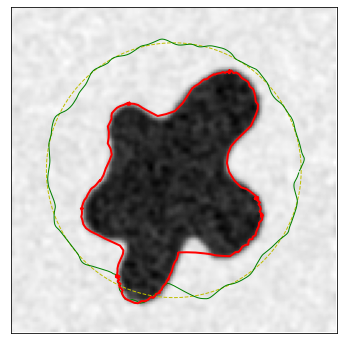

In [ ]:
# 1ST image
img_to_seg=img_mask; r0 = 130; c0=125; R0 = 60
img_to_seg=img_mask; r0 = 130; c0=125; R0 = 20
alpha_val  = 0.01 ; beta_val = 0.1 ;gamma_val = 0.01; convergence_val = 1e-4;Niter_snake = 800;
# alpha_val  = 0.01 ; beta_val = 0.1; gamma_val = 0.1; convergence_val = 1e-4; Niter_snake = 800;
# alpha_val  = 0.01 ; beta_val = 1; gamma_val = 0.01; convergence_val = 1e-4; Niter_snake = 800;

# 2ND image
# img_to_seg = img_star ; r0 = 64; c0=64; R0 = 50
img_to_seg = img_star_noisy ; r0 = 64; c0=64; R0 = 50
alpha_val  = 0.01 ; beta_val = 0.1; gamma_val = 0.01; convergence_val = 1e-4; Niter_snake = 800;


# Initialise contour
init = define_initial_circle(R0,r0,c0)

# Pre-smooth the image
Niter_smooth    = 1
img_to_seg      = gaussian(img_to_seg, Niter_smooth, preserve_range=False)

# Run active contour
snake10 = active_contour(img_to_seg,
                       init, max_iterations=10, convergence=convergence_val,
                         alpha=alpha_val, beta=beta_val, gamma=gamma_val)
snake_max = active_contour(img_to_seg,
                       init, max_iterations=Niter_snake, convergence=convergence_val,
                           alpha=alpha_val, beta=beta_val, gamma=gamma_val)

# Display results
fig, ax = plt.subplots(figsize=(6, 6));
ax.imshow(img_to_seg, cmap=plt.cm.gray);
ax.plot(init[:, 1], init[:, 0], '--y', lw=1);
ax.plot(snake10[:, 1], snake10[:, 0], '-g', lw=1);
ax.plot(snake_max[:, 1], snake_max[:, 0], '-r', lw=2);
ax.set_xticks([]), ax.set_yticks([]);
ax.axis([0, img_to_seg.shape[1], img_to_seg.shape[0], 0]);

plt.show();

# Seg #2:
### Snake on a real image

We are using here **img_to_seg   = img_cell** for which you have a ground truth mask of the target segmentation for the dark cell.  

## TODO
1. **Segment left cell**:
    1. Run with the proposed initialisation and see that the active contour can be initialised inside the object. Give some intuition on why.
2. **Segment right cell**:
    1. Run with the proposed initialisation and see that the active contour cannot be initialised inside the object now. Give some intuition on why.
    2. Change the parameter **Niter_smooth** while keeping snake parameters constant and give an intuition on why the final contour evolves as seen.
    1. Change the initial contour parameters to obtain a perfect segmentation.
3. BONUS: If you know that you are aiming for the darkest cell in the image, propose an automated initialisation of the initial active contour parameters [r0 ; c0; R0 ] that works on this image.



1. The contour can be initialized inside the object because the initial circle contour is sufficiently big to make the external forces act to attract the contour to the edges of the object. When we put lower radius to the initial circle, the final contours obtained are not so well.


2. Observing the image, it is possible to verify that the dark cell, which is the object we want to segment, is not "continuous". The dark cell presents some pieces and is very heterogeneous inside when compared to the other cells. The dark cell is also bigger than the other cells in the image. Hence, it could be interesting try an initialization with a bigger radius or in another position more centralized.

3. With bigger values of Niter_smooth, the contours can reach the nearest edges of the object. However, it is still not possible to obtain the real contours of the cell.  

4. With a radius equal to 65, keeping the other parameters unchanged, the result is satisfactory.



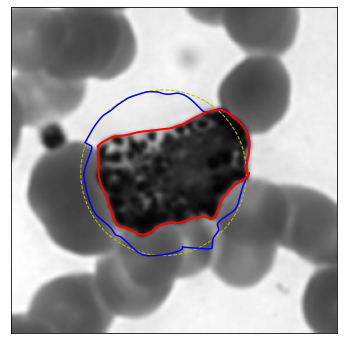

In [ ]:

# Input image and parameter values
img_to_seg = img_cell;

# 1st SEG: To segment left cell
r0 = 150; c0=50; R0 = 30
alpha_val = 0.01 ; beta_val = 0.1 ;gamma_val = 0.01; convergence_val = 1e-4; Niter_snake = 200;

# 2nd SEG: To segment center dark cell
r0 = 130; c0=120; R0 = 65
alpha_val = 0.01 ; beta_val = 0.1 ;gamma_val = 0.01;
convergence_val = 1e-4; Niter_snake = 800;

# Pre smooth the image
Niter_smooth = 1
img_to_seg   = gaussian(img_to_seg, Niter_smooth, preserve_range=False)


# Initialise contour
init = define_initial_circle(R0,r0,c0)

# Run active contour
snake30 = active_contour(img_to_seg,
                       init, max_iterations=30, convergence=convergence_val,
                         alpha=alpha_val, beta=beta_val, gamma=gamma_val)
snake = active_contour(img_to_seg,
                       init, max_iterations=Niter_snake, convergence=convergence_val,
                       alpha=alpha_val, beta=beta_val, gamma=gamma_val)

# Display results
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(img_to_seg, cmap=plt.cm.gray)
ax.plot(init[:, 1], init[:, 0], '--y', lw=1)
ax.plot(snake30[:, 1], snake30[:, 0], '-b', lw=1.5)
ax.plot(snake[:, 1], snake[:, 0], '-r', lw=2)
ax.set_xticks([]), ax.set_yticks([])
ax.axis([0, img_to_seg.shape[1], img_to_seg.shape[0], 0])

plt.show();

# Seg # 3

### A tool to visualise the deformations of the snake


## TO DO:
1. **Segment left cell**:
    1. Provide your comments on the deformation pattern of the snake.
    1. Why iteration time steps get slower over iterations when initialising from the inside?
1. **Segment right cell**:
     1. Use your optimal parameters from previous cell and comment on the deformation patterns.

1. Watching the small video of the evolution of the contour in the image it is possible to verify that the contour evolves fast at the beginning, but after it get slower. Also, it is possible to verify that the contour is adjusted in the edges of the object deforming as a "metal strip"

2. The iteration time steps get slower when initialising the contour inside the object because the first order term (elastic term), concerning the length of the contour in the internal energy is applied to minimize the changes along the points in the contour. It means that this term is applied to avoid that the contour stretch to fast from a control point to the next control point so that the segment between these two points is as small as possible. Therefore, this process tends to do the contour contract because when contracting the distance between the control points get smaller.

  When the contour is initialized inside the object, it is forced to expand and the elastic component in the internal energy makes it harder. Consequently, the expansion takes more time. One solution can be reduce the elasticity coefficient.


2. Setting the previous parameters it is possible to observe the action of the second order term in the internal Energy expression, as well as the first order term. These two terms are applied in order to control the changes in distances between the control points and the rate of change of the contour, avoiding that some points latch on the noise. Consequently, these term make the algorithm slow but less sensitive to noise and less sensitive to the way that the contour is initialized.

start
1  11  21  31  41  51  61  71  81  91  101  111  121  131  141  151  161  171  181  191  201  211  221  231  241  251  261  271  281  291  301  311  321  331  341  351  361  371  381  391  401  411  421  431  441  451  461  471  481  491  501  511  521  531  541  551  561  571  581  591  601  611  621  631  641  651  661  671  681  691  701  711  721  731  741  751  761  771  781  791  stop


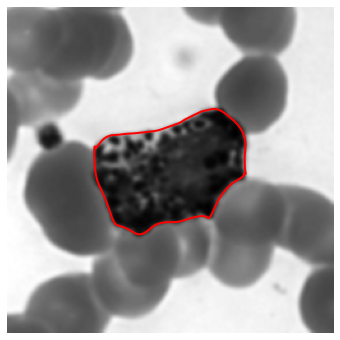

In [ ]:
img_to_seg        = img_cell

# 1st SEG: To segment left cell
r0 = 150; c0=50; R0 = 30
alpha_val = 0.01 ; beta_val = 0.1 ;gamma_val = 0.01; convergence_val = 1e-4; Niter_snake = 200;

# 2nd SEG: To segment center dark cell
# r0 = 130; c0=120; R0 = 30 # initialise inside
# alpha_val = 0.01 ; beta_val = 0.1 ;gamma_val = 0.01; convergence_val = 1e-4; Niter_snake = 200;
r0 = 130; c0=120; R0 = 65
alpha_val = 0.01 ; beta_val = 0.1 ;gamma_val = 0.01;
convergence_val = 1e-4; Niter_snake = 800;


# Pre smooth the image
Niter_smooth = 1
img_to_seg   = gaussian(img_to_seg, Niter_smooth, preserve_range=False)

# Initialise contour
init = define_initial_circle(R0,r0,c0)


# Run active contour while saving intermediate contours to see deformations
segs = []
print('start')
for i in range(1,Niter_snake+1,10):
    print(i, " ", end='')
    segs.append(active_contour(img_to_seg, init, max_iterations=i, convergence=convergence_val,
                alpha=alpha_val, beta=beta_val, gamma=gamma_val))

print('stop')
np.save('ANIM_contours.npy', np.array(segs))

# display animation
segs = np.load('ANIM_contours.npy')
anim = animate_snake(img_to_seg, segs);
HTML(anim.to_html5_video())

# Seg # 4

### Snake with  Gradient Vector Flow (GVF)
This implementation of the GVF is performed by computing the edge map, diffusing the gradient over the whole image and directly input the GVF_edge_map to be used as external forces by setting w_line=1 and w_edge=0 in the active_contour function.

## TODO:

1. Compare results when segmenting the Edge_map or GVF_map as input to the active_contour routine on 3 images: img_star, img_star_noisy and an image of your choice. Comment on robustness and speed differences.
1. When using GVF_map, test the effect of decreasing by a factor of 10 alpha,beta or gamma and interpret the effect.

1. Applying the edge map in the img_star, img_star_noisy and img_cell it is possible to do some observations about the application of edge maps in different situations. Firstly, it is interesting to observe that the edge map enhances the noise, consequently the contour obtained with the edge map of img_star_noisy is really bad adjusted.

  Also, the application of the edge map in the img_star without noise and in the img_cell did not imply in an improvement in the final contour. The noise present in the img_cell may have aggravated the bad result in this case.

  Applying the GVF map, the improvement is noticeable, mainly for the img_star. However on ly the first case (img_star) present a satisfactory result. The noise plays a important role in the both GVF and edge map cases.

2. Changing the value of alpha is equivalent to augment or reduce the relevance of the first order term in the Internal Energy Expression. It means that, in the case of an augmentation in alpha, the contour will act to reduce the distance between the control points acting as a rubber band, contracting until the edges. A simple augmentation in alpha of the order of 10^-3 suffis to improve considerably the result of the segmentation of the img_star_noisy image with the GVF map. On the other hand, when we reduce alpha, the contour tends to be more "rigid" reducing the contraction until the edges.

  Changing the value of beta is equivalent to augment/reduce the relevance of the second order term. In the augmenation case the contours tends to keep the oscillations as small as possible. In this case the algorithm will converge to the edges more slowly, but the contour obtained is more stable. However, when beta is reduced the contours will oscillate more.

  Gamma is the viscosity. An enhancement in viscosity gives more time to the forces to act in the contour. In practice, observing these three parameters in the gvf map of img_star_noisy, it is possible to observe that when we reduce gamma the contour approximates the edges of the star very quickly. Reducing beta makes the contour approximates to the edges more quickly but the result present some visible defects with sharp-edged contours. Reducing alpha with small values of beta and gamma augments the sharp-edge aspect, while with aproppriate values of beta and gamma, reducing alpha make the contours distant from the edges.   


In [ ]:
import sys
import imageio
import skimage.color
import skimage.data
import skimage.transform
try:
    import skimage.filters as skimage_filter
except:
    import skimage.filters as skimage_filter
import numpy as np
import matplotlib.pyplot as plt

def gradient_vector_flow(fx, fy, mu, dx=1.0, dy=1.0, verbose=True):
    u'''calc gradient vector flow of input gradient field fx, fy'''
    # calc some coefficients.
    b = fx**2.0 + fy**2.0
    c1, c2 = b*fx, b*fy
    # calc dt from scaling parameter r.
    r = 0.25 # (17) r < 1/4 required for convergence.
    dt = dx*dy/(r*mu)
    # max iteration
    N = int(max(1, np.sqrt(fx.shape[0]*fx.shape[1])))
    # initialize u(x, y), v(x, y) by the input.
    curr_u = fx
    curr_v = fy
    def laplacian(m):
        return np.hstack([m[:, 0:1], m[:, :-1]]) + np.hstack([m[:, 1:], m[:, -2:-1]]) \
                + np.vstack([m[0:1, :], m[:-1, :]]) + np.vstack([m[1:, :], m[-2:-1, :]]) \
                - 4*m
    for i in range(N):
        next_u = (1.0 - b*dt)*curr_u + r*laplacian(curr_u) + c1*dt
        next_v = (1.0 - b*dt)*curr_v + r*laplacian(curr_v) + c2*dt
        curr_u, curr_v = next_u, next_v
        if verbose:
            sys.stdout.write('.')
            sys.stdout.flush()
    if verbose:
        sys.stdout.write('\n')
    return curr_u, curr_v

def edge_map(img, sigma):
    blur = skimage.filters.gaussian(img, sigma)
    return skimage.filters.sobel(blur)

def gradient_field(im):
    im = skimage.filters.gaussian(im, 1.0)
    gradx = np.hstack([im[:, 1:], im[:, -2:-1]]) - np.hstack([im[:, 0:1], im[:, :-1]])
    grady = np.vstack([im[1:, :], im[-2:-1, :]]) - np.vstack([im[0:1, :], im[:-1, :]])
    return gradx, grady

def add_border(img, width):
    h, w = img.shape
    val = img[:, 0].mean() + img[:, -1].mean() + img[0, :].mean() + img[-1, :].mean()
    res = np.zeros((h + width*2, w + width*2), dtype=img.dtype) + val
    res[width:h+width, width:w+width] = img
    res[:width, :] = res[width, :][np.newaxis, :]
    res[:, :width] = res[:, width][:, np.newaxis]
    res[h+width:, :] = res[h+width-1, :][np.newaxis, :]
    res[:, w+width:] = res[:, w+width-1][:, np.newaxis]
    return res

................................................................................................................................
start
1  11  21  31  41  51  61  71  81  91  101  111  121  131  141  151  161  171  181  191  stop


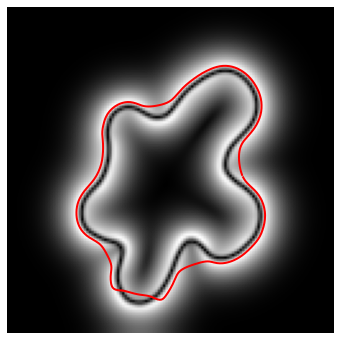

In [ ]:
# Image to seg
img_to_seg = img_star
r0 = 64; c0=64; R0 = 50

# Example of another image to test.
# NB: play with regularisation  parameter mu for gradient_vector_flow on real images
# img_to_seg        = img_cell
# r0 = 130; c0=120; R0 = 50 # initialise inside

alpha_val  = 0.05 ; beta_val = 0.1; gamma_val = 0.01;
convergence_val = 1e-4; Niter_snake = 200;

# Initialise contour
init        = define_initial_circle(R0,r0,c0,Nber_pts=400)

# Compute edge map and gvf
img_to_seg = img_to_seg.astype(np.float32) / np.max(img_to_seg)
Edge_map   = edge_map(img_to_seg,sigma=1)

fx, fy = gradient_field(Edge_map)
gx, gy = gradient_vector_flow(fx, fy, mu=5)
GVF_map = np.sqrt(gx**2 + gy**2)

# Run active contour while saving intermediate contours to see deformations
Map_to_seg = GVF_map

# Run active contour while saving intermediate contours to see deformations
segs = []
print('start')
for i in range(1,Niter_snake,10):
    print(i, " ", end='')
    segs.append(active_contour(Map_to_seg, init, max_iterations=i, convergence=convergence_val,
                alpha=alpha_val, beta=beta_val, gamma=gamma_val,
                    w_line=1,w_edge=0))

print('stop')
np.save('ANIM_contours.npy', np.array(segs))

# display animation
segs = np.load('ANIM_contours.npy')
anim = animate_snake(Map_to_seg, segs);
HTML(anim.to_html5_video())

................................................................................................................................
start
1  11  21  31  41  51  61  71  81  91  101  111  121  131  141  151  161  171  181  191  stop


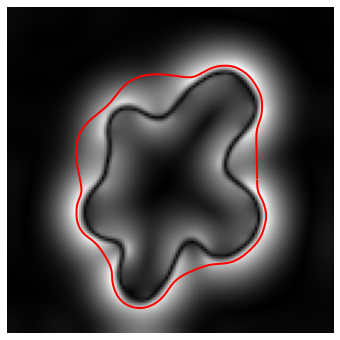

In [ ]:

# Image to seg
img_to_seg = img_star_noisy
r0 = 64; c0=64; R0 = 50

# Example of another image to test.
# NB: play with regularisation  parameter mu for gradient_vector_flow on real images
# img_to_seg        = img_cell
# r0 = 130; c0=120; R0 = 50 # initialise inside

alpha_val  = 0.01 ; beta_val = 0.1; gamma_val = 0.01;
convergence_val = 1e-4; Niter_snake = 200;


# Initialise contour
init        = define_initial_circle(R0,r0,c0,Nber_pts=400)

# Compute edge map and gvf
img_to_seg = img_to_seg.astype(np.float32) / np.max(img_to_seg)
Edge_map   = edge_map(img_to_seg,sigma=1)

fx, fy = gradient_field(Edge_map)
gx, gy = gradient_vector_flow(fx, fy, mu=5)
GVF_map = np.sqrt(gx**2 + gy**2)

# Run active contour while saving intermediate contours to see deformations
Map_to_seg = GVF_map

# Run active contour while saving intermediate contours to see deformations
segs = []
print('start')
for i in range(1,Niter_snake,10):
    print(i, " ", end='')
    segs.append(active_contour(Map_to_seg, init, max_iterations=i, convergence=convergence_val,
                alpha=alpha_val, beta=beta_val, gamma=gamma_val,
                    w_line=1,w_edge=0))

print('stop')
np.save('ANIM_contours.npy', np.array(segs))

# display animation
segs = np.load('ANIM_contours.npy')
anim = animate_snake(Map_to_seg, segs);
HTML(anim.to_html5_video())

................................................................................................................................................................................................................................................................
start
1  11  21  31  41  51  61  71  81  91  101  111  121  131  141  151  161  171  181  191  stop


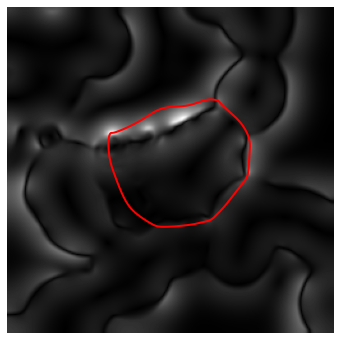

In [ ]:

# Image to seg
img_to_seg = img_cell
r0 = 120; c0=135; R0 = 55

# Example of another image to test.
# NB: play with regularisation  parameter mu for gradient_vector_flow on real images
# img_to_seg        = img_cell
# r0 = 130; c0=120; R0 = 50 # initialise inside

alpha_val  = 0.01 ; beta_val = 0.1; gamma_val = 0.01;
convergence_val = 1e-4; Niter_snake = 200;


# Initialise contour
init        = define_initial_circle(R0,r0,c0,Nber_pts=400)

# Compute edge map and gvf
img_to_seg = img_to_seg.astype(np.float32) / np.max(img_to_seg)
Edge_map   = edge_map(img_to_seg,sigma=1)

fx, fy = gradient_field(Edge_map)
gx, gy = gradient_vector_flow(fx, fy, mu=5)
GVF_map = np.sqrt(gx**2 + gy**2)

# Run active contour while saving intermediate contours to see deformations
Map_to_seg = GVF_map

# Run active contour while saving intermediate contours to see deformations
segs = []
print('start')
for i in range(1,Niter_snake,10):
    print(i, " ", end='')
    segs.append(active_contour(Map_to_seg, init, max_iterations=i, convergence=convergence_val,
                alpha=alpha_val, beta=beta_val, gamma=gamma_val,
                    w_line=1,w_edge=0))

print('stop')
np.save('ANIM_contours.npy', np.array(segs))

# display animation
segs = np.load('ANIM_contours.npy')
anim = animate_snake(Map_to_seg, segs);
HTML(anim.to_html5_video())

................................................................................................................................
start
1  11  21  31  41  51  61  71  81  91  101  111  121  131  141  151  161  171  181  191  stop


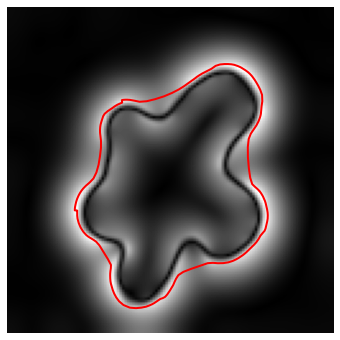

In [ ]:

# Image to seg
img_to_seg = img_star_noisy
r0 = 64; c0=64; R0 = 50

# Example of another image to test.
# NB: play with regularisation  parameter mu for gradient_vector_flow on real images
# img_to_seg        = img_cell
# r0 = 130; c0=120; R0 = 50 # initialise inside

alpha_val  = 0.001 ; beta_val = 0.0001; gamma_val = 0.001;
convergence_val = 1e-4; Niter_snake = 200;


# Initialise contour
init        = define_initial_circle(R0,r0,c0,Nber_pts=400)

# Compute edge map and gvf
img_to_seg = img_to_seg.astype(np.float32) / np.max(img_to_seg)
Edge_map   = edge_map(img_to_seg,sigma=1)

fx, fy = gradient_field(Edge_map)
gx, gy = gradient_vector_flow(fx, fy, mu=5)
GVF_map = np.sqrt(gx**2 + gy**2)

# Run active contour while saving intermediate contours to see deformations
Map_to_seg = GVF_map

# Run active contour while saving intermediate contours to see deformations
segs = []
print('start')
for i in range(1,Niter_snake,10):
    print(i, " ", end='')
    segs.append(active_contour(Map_to_seg, init, max_iterations=i, convergence=convergence_val,
                alpha=alpha_val, beta=beta_val, gamma=gamma_val,
                    w_line=1,w_edge=0))

print('stop')
np.save('ANIM_contours.npy', np.array(segs))

# display animation
segs = np.load('ANIM_contours.npy')
anim = animate_snake(Map_to_seg, segs);
HTML(anim.to_html5_video())

# Seg # 5:

### The active contour with fixed end points
You will now run the active_contour with the option to maintain some points from the inital contour fixed. You are working now with the img_nodule which is an ultrasound showing different layers of tissue under the skin surface.

## TO DO:
* Write a loop to vary the initial line vertical position by few pixels and propose a method to aggregate final contours, like for example a probability edge map.
* BONUS: Propose and implement a metric to measure the "quality" of the segmented contour, as being representative of the "interface" between two tissues.


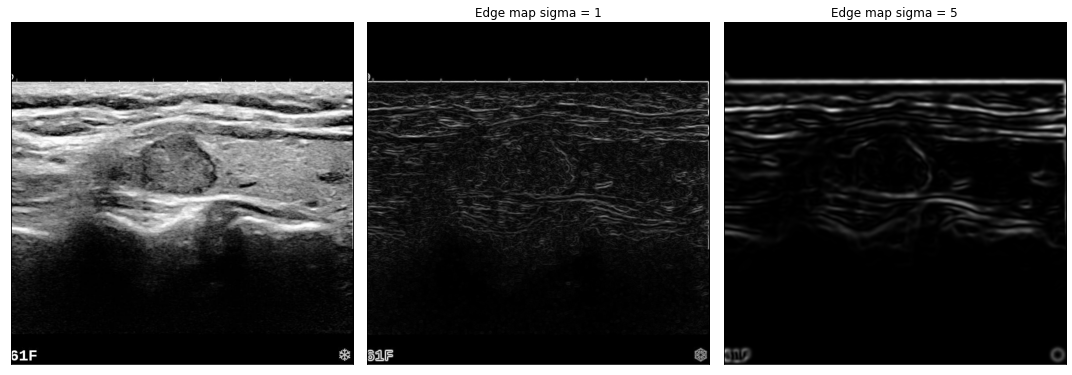

In [ ]:

img_to_test = img_nodule

# Classic Edge map with Gaussian smoothing controled by sigma
edge_test1         = edge_map(img_to_test, sigma=1)
edge_test2         = edge_map(img_to_test, sigma=5)
# edge_test2         = skimage.segmentation.inverse_gaussian_gradient(edge_test2, alpha=1.0, sigma=1.0)
edge_test2       = skimage.exposure.adjust_gamma(edge_test2, 2)
# edge_test2 = skimage.exposure.adjust_log(edge_test2, gain= 1,inv=True)
# edge_test2              = skimage.morphology.diameter_opening(edge_test2, 40, connectivity=2)
# edge_test2           = skimage.exposure.equalize_adapthist(edge_test2, clip_limit=0.03)

fig, axes = plt.subplots(1,3, figsize=(15, 15))
ax = axes.ravel()

ax[0].imshow(img_to_test, cmap=plt.cm.gray);

ax[1].imshow(edge_test1, cmap=plt.cm.gray);
ax[1].set_title("Edge map sigma = 1", fontsize=12);
ax[2].imshow(edge_test2, cmap=plt.cm.gray);
ax[2].set_title("Edge map sigma = 5", fontsize=12);


for i in range(0,3):
    ax[i].set_xticks([]), ax[i].set_yticks([]);

fig.tight_layout()
plt.show();

([], [])

[(0.0, 500.0)]

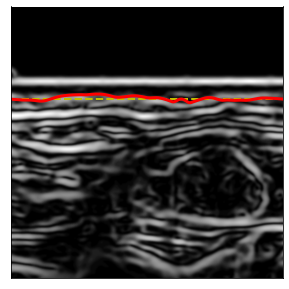

([], [])

[(0.0, 500.0)]

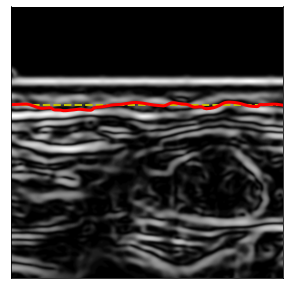

([], [])

[(0.0, 500.0)]

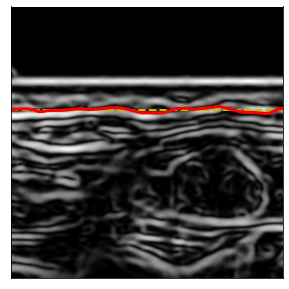

([], [])

[(0.0, 500.0)]

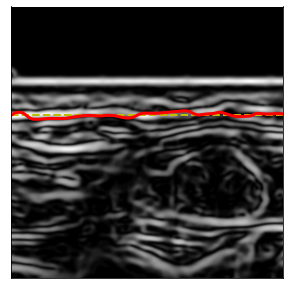

([], [])

[(0.0, 500.0)]

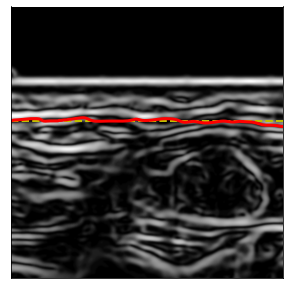

([], [])

[(0.0, 500.0)]

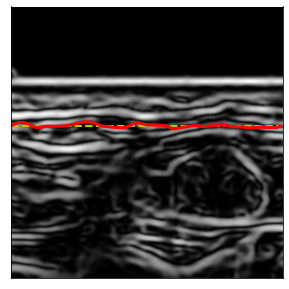

([], [])

[(0.0, 500.0)]

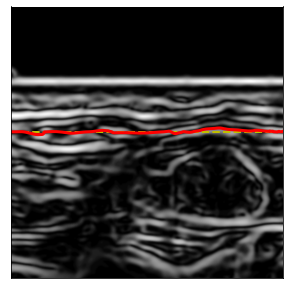

([], [])

[(0.0, 500.0)]

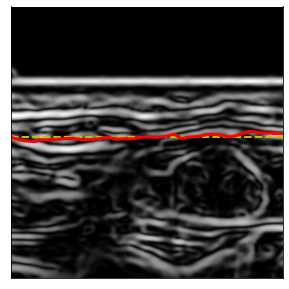

([], [])

[(0.0, 500.0)]

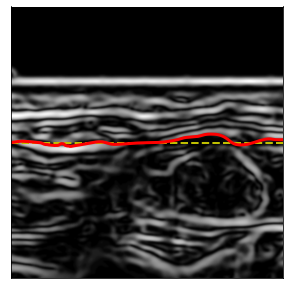

([], [])

[(0.0, 500.0)]

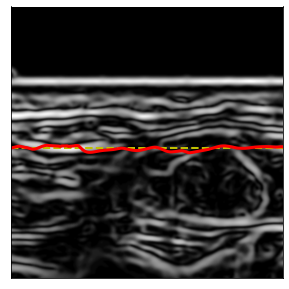

([], [])

[(0.0, 500.0)]

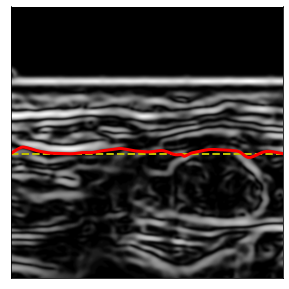

([], [])

[(0.0, 500.0)]

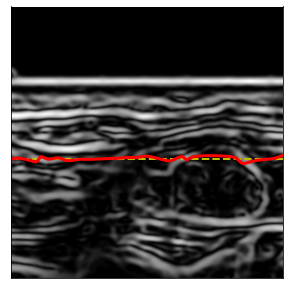

([], [])

[(0.0, 500.0)]

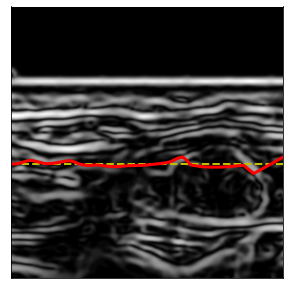

([], [])

[(0.0, 500.0)]

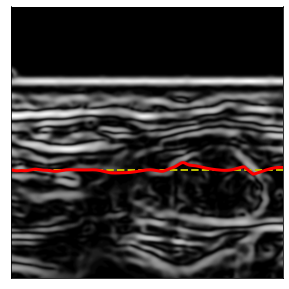

([], [])

[(0.0, 500.0)]

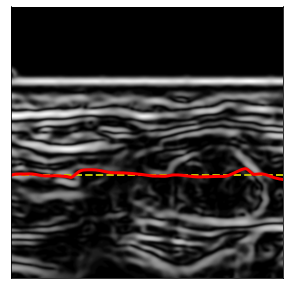

([], [])

[(0.0, 500.0)]

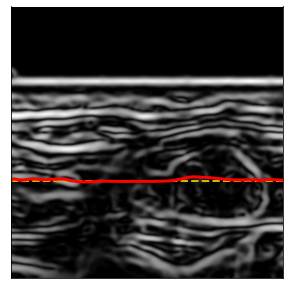

([], [])

[(0.0, 500.0)]

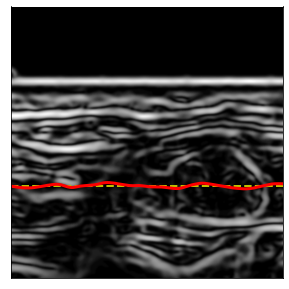

([], [])

[(0.0, 500.0)]

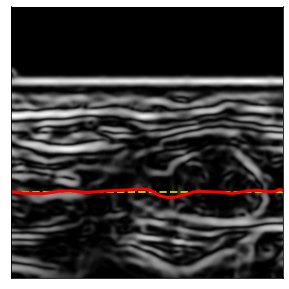

In [ ]:

img_to_seg = edge_test2
r_left = 170; r_right=170; c_left=0; c_right = 780
#r_left = 200; r_right=190; c_left=0; c_right = 780
#r_left = 230; r_right=210; c_left=0; c_right = 780

alpha_val  = 0.01 ; beta_val = 0.1; gamma_val = 0.01;
convergence_val = 1e-4; Niter_snake = 500;
w_line_val=0; w_edge_val=1

# Pre smooth the image
img_to_seg   = skimage.exposure.equalize_adapthist(img_to_seg, clip_limit=0.03)
Niter_smooth = 1
img_to_seg   = gaussian(img_to_seg, Niter_smooth, preserve_range=False)

# img_to_seg = edge_map(img_to_seg,Niter_smooth)

# Initialise contour
for i in range(170, 350, 10):
  Nber_pts_contour = 300
  r          = np.linspace(i, i, Nber_pts_contour)
  c          = np.linspace(c_left, c_right, Nber_pts_contour)
  init       = np.array([r, c]).T


  snake = active_contour(img_to_seg,
                        init, boundary_condition='fixed-fixed',max_iterations=Niter_snake,
                        alpha=alpha_val, beta=beta_val, gamma=gamma_val,
                        w_line=w_line_val, w_edge=w_edge_val)

  fig, ax = plt.subplots(figsize=(9, 5));
  ax.imshow(img_to_seg[0:500,:], cmap=plt.cm.gray);
  ax.plot(init[:, 1], init[:, 0], '--y', lw=2);
  ax.plot(snake[:, 1], snake[:, 0], '-r', lw=3);
  ax.set_xticks([]), ax.set_yticks([]);
  ax.set(xlim=(0, 500));
  plt.show();

# Seg # 6

### Your turn on proposing a motivated pipeline using the snake capabilities from the active_contour function

## TODO:
Choose a new image in the pool provided and propose a segmentation pipeline using the active_contour approach. Options on points to work on include: <br>
* Pre filter the image as you wish
* Manually or automatically position the initial contour
* Provide one segmentation result or merge several solutions in a probability map
* Detect issues in contour shape during deformations and propose an early stop criteria.

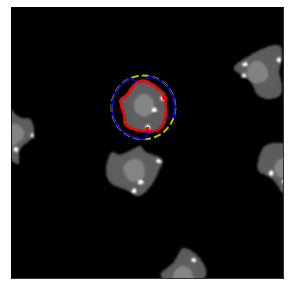

In [ ]:
## Pre-filter
img_to_seg = skimage.io.imread(path+'/images_misc/syncell_gt.png', as_gray = True)

img_to_seg   = skimage.exposure.equalize_adapthist(img_to_seg, clip_limit=0.03)
Niter_smooth = 1
img_to_seg   = gaussian(img_to_seg, Niter_smooth, preserve_range=False)

## Number of iterations

Niter_snake = 140

## Positioning the initial contour

r0 = 95; c0=125; R0 = 30
init = define_initial_circle(R0,r0,c0)

## Segmentation
snake30 = active_contour(img_to_seg,
                       init, max_iterations=30, convergence=convergence_val,
                         alpha=alpha_val, beta=beta_val, gamma=gamma_val)
snake = active_contour(img_to_seg,
                       init, max_iterations=Niter_snake, convergence=convergence_val,
                       alpha=alpha_val, beta=beta_val, gamma=gamma_val)

fig, ax = plt.subplots(figsize=(9, 5));
ax.imshow(img_to_seg, cmap="gray");
ax.plot(init[:, 1], init[:, 0], '--y', lw=2);
ax.plot(snake30[:, 1], snake30[:, 0], '-b', lw=1.5)
ax.plot(snake[:, 1], snake[:, 0], '-r', lw=2)
ax.set_xticks([]), ax.set_yticks([])
ax.axis([0, img_to_seg.shape[1], img_to_seg.shape[0], 0])
plt.show();




start
1  11  21  31  41  51  61  71  81  91  101  111  121  131  141  stop


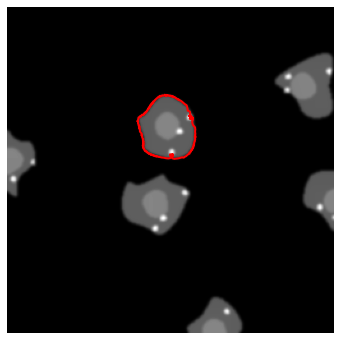

In [ ]:
# Run active contour while saving intermediate contours to see deformations
segs = []
print('start')
for i in range(1,Niter_snake+5,10):
    print(i, " ", end='')
    segs.append(active_contour(img_to_seg, init, max_iterations=i, convergence=convergence_val,
                alpha=alpha_val, beta=beta_val, gamma=gamma_val))

print('stop')

np.save('ANIM_contours.npy', np.array(segs))

# display animation
segs = np.load('ANIM_contours.npy')
anim = animate_snake(img_to_seg, segs);
HTML(anim.to_html5_video())

# Seg #7

### Test on the Geometric Level-Set formulation using the Chan-Vese model.
Skimage provides two implementations of the Chan-Vese approach: **morphological_chan_vese** and **chan_vese**. <br>

The contours of ojects are now encoded in a level set function **Phi**.

The **initialisation** tested here is with a "checkerboard" pattern for 2 classes (object and background). <br>

For the **chan_vese** original implementation, the **hyper-parameters** include:<br>
* mu = 0.25 (default) | edge regularisation terms. Similar to ‘edge length’ weight parameter. Higher mu values will produce ‘smoother’ contours.
* dt = 0.5 (default) |  delta time step for each optimisation step.  
* lambda1=1, lambda2=1 (default) | weights in the cost metric to balance inside and outside homogeneity terms.
* tol=1e-3 (default) | Tolerance to test if the contours are "stable" and stop early.

The output contains: cv[0]=Seg and cv[1]=Phi <br>

For the **morphological_chan_vese**  implementation, the only **hyper-parameter** is the number of smoothing iterations (1 to 4 recommended).<br>

## TO DO:
1. C-V ori: Run the code on img_hela. Visualise and explain  evolution of Phi over first iterations. Figure out how to see the initial Phi configuration.
1. Run now on img_cell without and with pre-processing with histogram equalisation and explain difference in results.
1. Propose and implement method(s) and metrics to compare two segmentation results when handling segmentation masks. Use the one(s) implemented to quantify the differences obtained on one test case of your choice with the two implementations of chan-vese provided here.
1. Make the level set work when initialising with "disk" on img_MRIf


1. Looking to the image below presenting the evolution of the energy (Phi) during iterations, it is possible to verify that over the first iterations the energy is reduced. Near to the 6th iteration the Phi is minimum.

  From the 6th to the 30th iteration the Phi increases until a local maximum. From 30th to the 40th it decreases a little and, finally, near the 40th iteration Phi increases until its global maximum.

2. It is possible to observe the importance of the pre-processing in this aplication of Chan-Vese model. The image without pre-processing presents a bad segmentation with several cells fused, making it difficult to identify the cells. However, applying the pre-processing with histogram equalization it is easier to identify the different cells, although some cells are still fused.

  The image equalized presents better results because the histogram equalization increases the global constrast of the image, allowing areas of lower constrast to gain a higher contrast.

3. There are some metrics to evaluate a segmentation model as: Jaccar Index (Intersection-Over Union), F1 Score (Dice Coefficient) or Pixel Accuracy.  

  Applying the two implementation methods in the img_hela it is possible to verify that in this case the two methods show a similar result. Calculating the F1 score with the f1_score function implemented below it is possible to confirm that in this specific case the two methods (CV original and Morphological CV) present a very similar performance with F1 scores of 55% and 56%.

4. (Answer in the code below)

In [ ]:
def f1_score(y_true, y_pred, smooth=1):
  y_true = y_true.astype("uint8")
  # print(np.min(y_true))
  tp = np.sum((y_true > 2) & (y_pred == 1))
  tn = np.sum((y_true < 2) & (y_pred == 0))
  fn = np.sum((y_true > 2) & (y_pred == 0))
  fp = np.sum((y_true < 2) & (y_pred == 1))

  recall = (tp  * 100)/ float( tp + fn)
  precision = (tp  * 100)/ float( tp + fp)

  return (2*tp)/(2*tp+fp+fn)

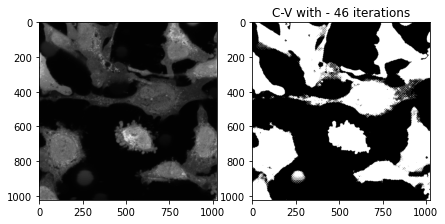

In [ ]:
img_to_seg= img_hela

# PARAMETERS
mu_val=0.5 ; lambda1_val=1; lambda2_val=1; tol_val=1e-3; dt_val=0.5
smoothing_val = 3

Num_iter_cv_ori    = 100
Num_iter_cv_fast   = 1

CHAN_VESE_ORI  = 1
Init_method    = "checkerboard" # "checkerboard" or "disk" or "small disk" (alternative to use to set init_level_set)


# run segmentation
if CHAN_VESE_ORI == 1:
    # STANDARD implementation from original paper
    init_ls = checkerboard_level_set(img_to_seg.shape, 45)

    cv = chan_vese(img_to_seg, mu=mu_val, lambda1=lambda1_val, lambda2=lambda2_val,
                   tol=tol_val, dt=dt_val,
                   max_iter=Num_iter_cv_ori, init_level_set=Init_method,
                   extended_output=True)
    fig, ax = plt.subplots(1,2,figsize=(7, 7))
    ax[0].imshow(img_to_seg, cmap=plt.cm.gray)
    ax[1].imshow(1-cv[0], cmap=plt.cm.gray)
    title = f'C-V with - {len(cv[2])} iterations'
    ax[1].set_title(title, fontsize=12)

else:
    # FASTER implementation implemented with morphological operators BUT LESS PRECISE
    cv      = morphological_chan_vese(img_to_seg, num_iter=Num_iter_cv_fast,
                                      smoothing=smoothing_val, init_level_set="checkerboard")
    fig, ax = plt.subplots(1,2,figsize=(7, 7))
    ax[0].imshow(img_to_seg, cmap=plt.cm.gray)
    ax[1].imshow(1-cv, cmap=plt.cm.gray)
    title = f'C-V_morph with - {Num_iter_cv_fast} iterations'
    ax[1].set_title(title, fontsize=12)


plt.show();

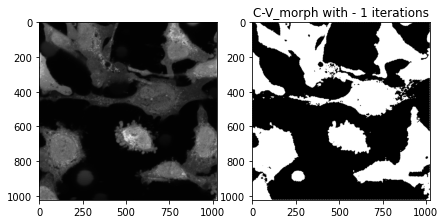

In [ ]:
img_to_seg= img_hela

# PARAMETERS
mu_val=0.5 ; lambda1_val=1; lambda2_val=1; tol_val=1e-3; dt_val=0.5
smoothing_val = 3

Num_iter_cv2_ori    = 100
Num_iter_cv2_fast   = 1

CHAN_VESE_ORI  = 0
Init_method    = "checkerboard" # "checkerboard" or "disk" or "small disk" (alternative to use to set init_level_set)

# run segmentation
if CHAN_VESE_ORI == 1:
    # STANDARD implementation from original paper
    init_ls = checkerboard_level_set(img_to_seg.shape, 45)

    cv2 = chan_vese(img_to_seg, mu=mu_val, lambda1=lambda1_val, lambda2=lambda2_val,
                   tol=tol_val, dt=dt_val,
                   max_iter=Num_iter_cv2_ori, init_level_set=Init_method,
                   extended_output=True)
    fig, ax = plt.subplots(1,2,figsize=(7, 7))
    ax[0].imshow(img_to_seg, cmap=plt.cm.gray)
    ax[1].imshow(1-cv2[0], cmap=plt.cm.gray)
    title = f'C-V with - {len(cv2[2])} iterations'
    ax[1].set_title(title, fontsize=12)

else:
    # FASTER implementation implemented with morphological operators BUT LESS PRECISE
    cv2      = morphological_chan_vese(img_to_seg, Num_iter_cv2_fast,
                                     init_level_set="checkerboard", smoothing=smoothing_val)
    fig, ax = plt.subplots(1,2,figsize=(7, 7))
    ax[0].imshow(img_to_seg, cmap=plt.cm.gray)
    ax[1].imshow(1-cv2, cmap=plt.cm.gray)
    title = f'C-V_morph with - {Num_iter_cv2_fast} iterations'
    ax[1].set_title(title, fontsize=12)


plt.show();

Text(0.5, 1.0, 'Phi x Iteration')

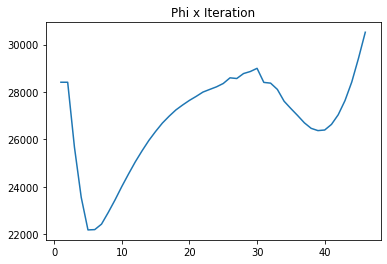

In [ ]:
## Evolution of Phi over iterations
nIter = np.linspace(1, len(cv[2]), len(cv[2]))

plt.plot(nIter, cv[2])
plt.title("Phi x Iteration")

In [ ]:
dice1 = f1_score(img_hela, 1-cv[0])
dice2 = f1_score(img_hela, 1-cv2)

print( "F1 score to CV original =", dice1, "\n",
        "F1 score to Morph. CV = ", dice2)

F1 score to CV original = 0.5523447412273254 
 F1 score to Morph. CV =  0.5651142837203001


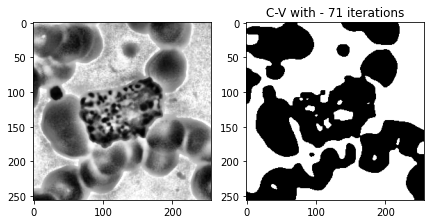

In [ ]:
## With pre-processing

img_to_seg= img_cell

# Histogram equalization
img_to_seg   = skimage.exposure.equalize_adapthist(img_to_seg, clip_limit=0.03)

# PARAMETERS
mu_val=0.5 ; lambda1_val=1; lambda2_val=1; tol_val=1e-3; dt_val=0.5
smoothing_val = 3

Num_iter_cv_ori    = 100
Num_iter_cv_fast   = 1

CHAN_VESE_ORI  = 1
Init_method    = "checkerboard" # "checkerboard" or "disk" or "small disk" (alternative to use to set init_level_set)


# run segmentation
if CHAN_VESE_ORI == 1:
    # STANDARD implementation from original paper
    init_ls = checkerboard_level_set(img_to_seg.shape, 45)

    cv = chan_vese(img_to_seg, mu=mu_val, lambda1=lambda1_val, lambda2=lambda2_val,
                   tol=tol_val, dt=dt_val,
                   max_iter=Num_iter_cv_ori, init_level_set=Init_method,
                   extended_output=True)
    fig, ax = plt.subplots(1,2,figsize=(7, 7))
    ax[0].imshow(img_to_seg, cmap=plt.cm.gray)
    ax[1].imshow(1-cv[0], cmap=plt.cm.gray)
    title = f'C-V with - {len(cv[2])} iterations'
    ax[1].set_title(title, fontsize=12)

else:
    # FASTER implementation implemented with morphological operators BUT LESS PRECISE
    cv      = morphological_chan_vese(img_to_seg, num_iter=Num_iter_cv_fast,
                                      smoothing=smoothing_val, init_level_set="checkerboard")
    fig, ax = plt.subplots(1,2,figsize=(7, 7))
    ax[0].imshow(img_to_seg, cmap=plt.cm.gray)
    ax[1].imshow(1-cv, cmap=plt.cm.gray)
    title = f'C-V_morph with - {Num_iter_cv_fast} iterations'
    ax[1].set_title(title, fontsize=12)


plt.show();

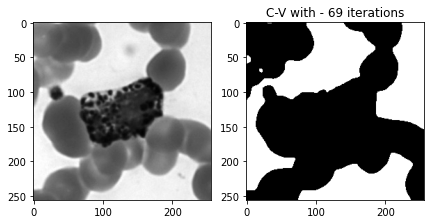

In [ ]:
## Without pre-processing

img_to_seg= img_cell

# PARAMETERS
mu_val=0.5 ; lambda1_val=1; lambda2_val=1; tol_val=1e-3; dt_val=0.5
smoothing_val = 3

Num_iter_cv_ori    = 100
Num_iter_cv_fast   = 1

CHAN_VESE_ORI  = 1
Init_method    = "checkerboard" # "checkerboard" or "disk" or "small disk" (alternative to use to set init_level_set)


# run segmentation
if CHAN_VESE_ORI == 1:
    # STANDARD implementation from original paper
    init_ls = checkerboard_level_set(img_to_seg.shape, 45)

    cv = chan_vese(img_to_seg, mu=mu_val, lambda1=lambda1_val, lambda2=lambda2_val,
                   tol=tol_val, dt=dt_val,
                   max_iter=Num_iter_cv_ori, init_level_set=Init_method,
                   extended_output=True)
    fig, ax = plt.subplots(1,2,figsize=(7, 7))
    ax[0].imshow(img_to_seg, cmap=plt.cm.gray)
    ax[1].imshow(1-cv[0], cmap=plt.cm.gray)
    title = f'C-V with - {len(cv[2])} iterations'
    ax[1].set_title(title, fontsize=12)

else:
    # FASTER implementation implemented with morphological operators BUT LESS PRECISE
    cv      = morphological_chan_vese(img_to_seg, num_iter=Num_iter_cv_fast,
                                      smoothing=smoothing_val, init_level_set="checkerboard")
    fig, ax = plt.subplots(1,2,figsize=(7, 7))
    ax[0].imshow(img_to_seg, cmap=plt.cm.gray)
    ax[1].imshow(1-cv, cmap=plt.cm.gray)
    title = f'C-V_morph with - {Num_iter_cv_fast} iterations'
    ax[1].set_title(title, fontsize=12)


plt.show();

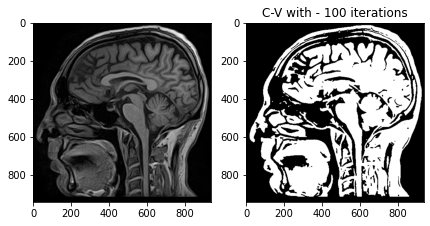

In [ ]:
img_to_seg= img_MRIb

# PARAMETERS
mu_val=0.5 ; lambda1_val=50; lambda2_val=50; tol_val=1e-10; dt_val=0.5
smoothing_val = 3

Num_iter_cv_ori    = 100
Num_iter_cv_fast   = 1

CHAN_VESE_ORI  = 1
Init_method    = "disk" # "checkerboard" or "disk" or "small disk" (alternative to use to set init_level_set)


# run segmentation
if CHAN_VESE_ORI == 1:
    # STANDARD implementation from original paper
    init_ls = checkerboard_level_set(img_to_seg.shape, 45)

    cv = chan_vese(img_to_seg, mu=mu_val, lambda1=lambda1_val, lambda2=lambda2_val,
                   tol=tol_val, dt=dt_val,
                   max_iter=Num_iter_cv_ori, init_level_set=Init_method,
                   extended_output=True)
    fig, ax = plt.subplots(1,2,figsize=(7, 7))
    ax[0].imshow(img_to_seg, cmap=plt.cm.gray)
    ax[1].imshow(cv[0], cmap=plt.cm.gray)
    title = f'C-V with - {len(cv[2])} iterations'
    ax[1].set_title(title, fontsize=12)

else:
    # FASTER implementation implemented with morphological operators BUT LESS PRECISE
    cv      = morphological_chan_vese(img_to_seg, num_iter=Num_iter_cv_fast,
                                      smoothing=smoothing_val, init_level_set="checkerboard")
    fig, ax = plt.subplots(1,2,figsize=(7, 7))
    ax[0].imshow(img_to_seg, cmap=plt.cm.gray)
    ax[1].imshow(1-cv, cmap=plt.cm.gray)
    title = f'C-V_morph with - {Num_iter_cv_fast} iterations'
    ax[1].set_title(title, fontsize=12)


plt.show();

# Seg # 8

## Geometric active contours with balloon force

You are now also provided with a tool to track the deformation patterns of the active contour over iterations. <br>

The geometric active contour routine is **morphological_geodesic_active_contour** which deforms a level set function with local speed values. It has the following **hyper-parameters** :<br>
* Thresh_cont_val  = 'auto'=> np.percentile(image, 40) (default if 'auto')  | pixels < Thresh_cont_val are considered borders. The evolution of the contour will stop on these pixels. Threshold_mask_balloon = image > threshold / np.abs(Balloon_weight)
* Balloon_weight   = 1 (default) | weight of the balloon force. Can be negative to inflate/deflat
* Smooth_cont_iter = 1 (default) |  Number of times a smoothing operator is applied per iteration


# TO DO:
* Segment the img_cell with the provided configuration in line 1 to inflate the initial contour. What is the issue?
* Now Segment the img_cell with the provided configuration in line 2 to deflate the initial contour. Adjust balloon parameter accordingly. Fix the issues observed to get a perfect segmentation in 30 iterations.
* Segment the img_MRIb image with the configuration in line 3 set to inflate an initial contour. Comment issues seen with high and low smoothness regularisation over 300 iterations.
* Now propose and run a setup to attempt to segment the gray matter contours in img_MRIb or some structure in another image. Comment on your choice of parameters, number of iterations and observed quality of contours.



* Concerning the first configuration to inflate the initial contour, it is possible to observe that the result presents some problems, such as in the left superior region and in some edges that are not so well adjusted. To solve these problems it is possible to augment the balloon weight in a factor of 10^-2. Putting a balloon weight equal to 1.07 presents a better result but it is still possible to observe that some regions are not perfect adjusted.

* (Answer in the code below)

* Applying a ballon weight equal to one and a high and a low values of smothness equal to 4 and 1, respectively, with 300 iterations, it is possible to verify the effects of different smoothness in the GAC.

  In the case of the high value of smoothness the algorithm is only capable to segment the brain stem, while with the low value the algorithm segments the brain stem and a part of the spinal cord.
For bigger values of smoothness the algorithm takes a long time to give a result.

* The setup to segment the gray matter is presented below. Initially, I fixed a number of 100 iteration after try other numbers. For more iterations the contours exceeded the gray matter. The balloon weight was choosen in an analogous way.

  After fix the iterations and the balloon weight I tried to figure out the initialisation of the contours. I tried to apply the checkerboard pattern but it did not work well. Hence, I initialized the contours with 6 disks positioned inside the brain along the gray matter. The result is presented below.

0.7377611236173724


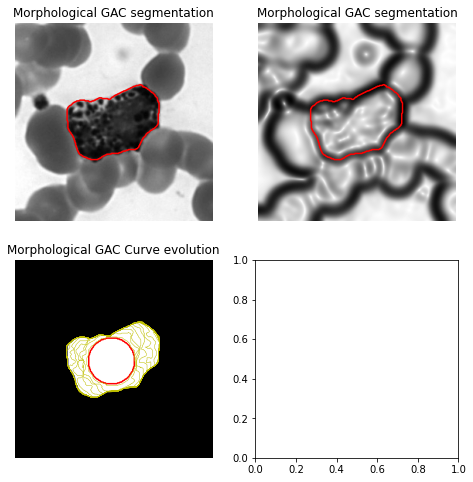

In [ ]:


img_to_seg = img_cell ; r0 = 130;  c0 = 125 ; R0 = 30  # inflate
#img_to_seg = img_cell ; r0 = 130;  c0 = 125 ; R0 = 70  # deflate
#img_to_seg = img_MRIb ; r0 = 500 ; c0 = 530 ; R0 = 30  # for spine and inflate



SMOOTHING    = 0; Niter_smooth = 3
INV_EDGE_MAP = 1; # needed when using the Balloon force

img_ori    = img_to_seg

# Hyper parameters for snake and balloon
Thresh_cont_val  = 'auto' ; Balloon_weight   = 1.07; Smooth_cont_iter = 1 ;
Niter_snake      = 100

# smoothing
if SMOOTHING:
    img_to_seg = gaussian(img_to_seg, Niter_smooth, preserve_range=False)

# Test segment directly on edge image [QUESTION: WHY IS THE RESULT DIFFERENT?]
if INV_EDGE_MAP:
    img_to_seg = skimage.segmentation.inverse_gaussian_gradient(img_to_seg) # Compute the magnitude of the gradients in the image and then inverts the result in the range [0, 1]

#Print threshold used by "auto"
print(np.percentile(img_to_seg, 40))


# initialise call back
evolution = []
callback = store_evolution_in(evolution)

# Initialise contour
init_ls  = skimage.segmentation.disk_level_set(img_to_seg.shape, center=[r0,c0], radius=R0)

# Run geodesic active contour
ls       = morphological_geodesic_active_contour(
            img_to_seg, Niter_snake, init_ls,
            smoothing=Smooth_cont_iter, balloon=Balloon_weight,
            threshold=Thresh_cont_val,
            iter_callback=callback);


fig, axes = plt.subplots(2, 2, figsize=(8, 8));
ax = axes.flatten();

ax[0].imshow(img_ori, cmap="gray");
ax[0].set_axis_off();
ax[0].contour(ls, [0.5], colors='r');
ax[0].set_title("Morphological GAC segmentation", fontsize=12);

ax[1].imshow(img_to_seg, cmap="gray");
ax[1].set_axis_off();
ax[1].contour(ls, [0.5], colors='r');
ax[1].set_title("Morphological GAC segmentation", fontsize=12);

ax[2].imshow(ls, cmap="gray");
ax[2].set_axis_off();
contour = ax[2].contour(evolution[0], [0.5], colors='r');
contour.collections[0].set_label("Contours");
title = f'Morphological GAC Curve evolution';
ax[2].set_title(title, fontsize=12);
for i in range(1, Niter_snake-1, 5):
  contour = ax[2].contour(evolution[i], [0.01], linewidths=0.5, colors='y');
plt.show();

0.7377611236173724


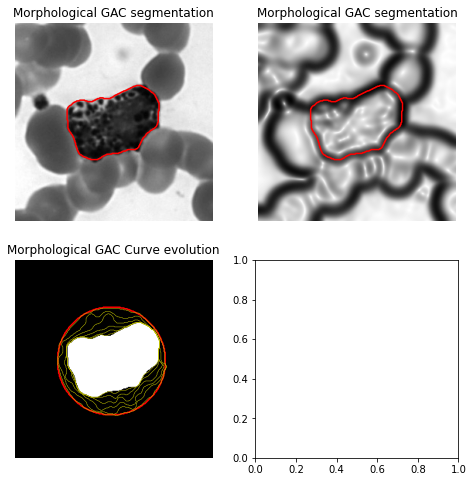

In [ ]:


# img_to_seg = img_cell ; r0 = 130;  c0 = 125 ; R0 = 30  # inflate
img_to_seg = img_cell ; r0 = 130;  c0 = 125 ; R0 = 70  # deflate
#img_to_seg = img_MRIb ; r0 = 500 ; c0 = 530 ; R0 = 30  # for spine and inflate



SMOOTHING    = 0; Niter_smooth = 3
INV_EDGE_MAP = 1; # needed when using the Balloon force

img_ori    = img_to_seg

# Hyper parameters for snake and balloon
Thresh_cont_val  = 'auto' ; Balloon_weight   = -1 ; Smooth_cont_iter = 4 ;
Niter_snake      = 30

# smoothing
if SMOOTHING:
    img_to_seg = gaussian(img_to_seg, Niter_smooth, preserve_range=False)

# Test segment directly on edge image [QUESTION: WHY IS THE RESULT DIFFERENT?]
if INV_EDGE_MAP:
    img_to_seg = skimage.segmentation.inverse_gaussian_gradient(img_to_seg) # Compute the magnitude of the gradients in the image and then inverts the result in the range [0, 1]

#Print threshold used by "auto"
print(np.percentile(img_to_seg, 40))


# initialise call back
evolution = []
callback = store_evolution_in(evolution)

# Initialise contour
init_ls  = skimage.segmentation.disk_level_set(img_to_seg.shape, center=[r0,c0], radius=R0)

# Run geodesic active contour
ls       = morphological_geodesic_active_contour(
            img_to_seg, Niter_snake, init_ls,
            smoothing=Smooth_cont_iter, balloon=Balloon_weight,
            threshold=Thresh_cont_val,
            iter_callback=callback);


fig, axes = plt.subplots(2, 2, figsize=(8, 8));
ax = axes.flatten();

ax[0].imshow(img_ori, cmap="gray");
ax[0].set_axis_off();
ax[0].contour(ls, [0.5], colors='r');
ax[0].set_title("Morphological GAC segmentation", fontsize=12);

ax[1].imshow(img_to_seg, cmap="gray");
ax[1].set_axis_off();
ax[1].contour(ls, [0.5], colors='r');
ax[1].set_title("Morphological GAC segmentation", fontsize=12);

ax[2].imshow(ls, cmap="gray");
ax[2].set_axis_off();
contour = ax[2].contour(evolution[0], [0.5], colors='r');
contour.collections[0].set_label("Contours");
title = f'Morphological GAC Curve evolution';
ax[2].set_title(title, fontsize=12);
for i in range(1, Niter_snake-1, 5):
  contour = ax[2].contour(evolution[i], [0.01], linewidths=0.5, colors='y');
plt.show();

0.785146875520775


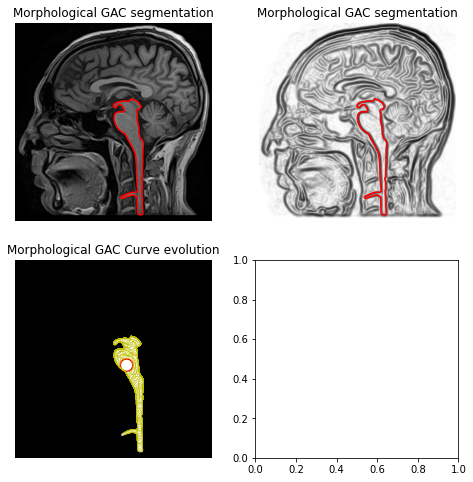

In [ ]:


# img_to_seg = img_cell ; r0 = 130;  c0 = 125 ; R0 = 30  # inflate
# img_to_seg = img_cell ; r0 = 130;  c0 = 125 ; R0 = 70  # deflate
img_to_seg = img_MRIb ; r0 = 500 ; c0 = 530 ; R0 = 30  # for spine and inflate



SMOOTHING    = 0; Niter_smooth = 3
INV_EDGE_MAP = 1; # needed when using the Balloon force

img_ori    = img_to_seg

# Hyper parameters for snake and balloon
Thresh_cont_val  = 'auto' ; Balloon_weight   = 1 ; Smooth_cont_iter = 1 ;
Niter_snake      = 300

# smoothing
if SMOOTHING:
    img_to_seg = gaussian(img_to_seg, Niter_smooth, preserve_range=False)

# Test segment directly on edge image [QUESTION: WHY IS THE RESULT DIFFERENT?]
if INV_EDGE_MAP:
    img_to_seg = skimage.segmentation.inverse_gaussian_gradient(img_to_seg) # Compute the magnitude of the gradients in the image and then inverts the result in the range [0, 1]

#Print threshold used by "auto"
print(np.percentile(img_to_seg, 40))


# initialise call back
evolution = []
callback = store_evolution_in(evolution)

# Initialise contour
init_ls  = skimage.segmentation.disk_level_set(img_to_seg.shape, center=[r0,c0], radius=R0)

# Run geodesic active contour
ls       = morphological_geodesic_active_contour(
            img_to_seg, Niter_snake, init_ls,
            smoothing=Smooth_cont_iter, balloon=Balloon_weight,
            threshold=Thresh_cont_val,
            iter_callback=callback);


fig, axes = plt.subplots(2, 2, figsize=(8, 8));
ax = axes.flatten();

ax[0].imshow(img_ori, cmap="gray");
ax[0].set_axis_off();
ax[0].contour(ls, [0.5], colors='r');
ax[0].set_title("Morphological GAC segmentation", fontsize=12);

ax[1].imshow(img_to_seg, cmap="gray");
ax[1].set_axis_off();
ax[1].contour(ls, [0.5], colors='r');
ax[1].set_title("Morphological GAC segmentation", fontsize=12);

ax[2].imshow(ls, cmap="gray");
ax[2].set_axis_off();
contour = ax[2].contour(evolution[0], [0.5], colors='r');
contour.collections[0].set_label("Contours");
title = f'Morphological GAC Curve evolution';
ax[2].set_title(title, fontsize=12);
for i in range(1, Niter_snake-1, 5):
  contour = ax[2].contour(evolution[i], [0.01], linewidths=0.5, colors='y');
plt.show();

0.785146875520775


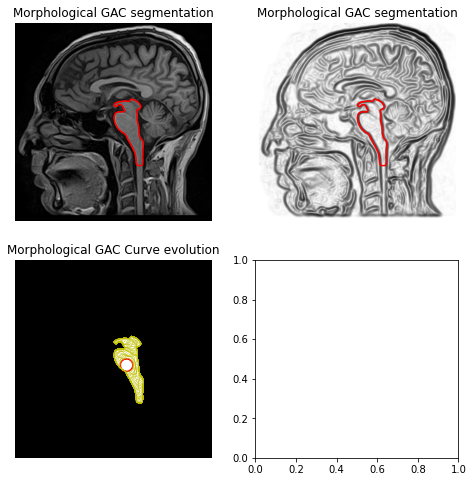

In [ ]:


# img_to_seg = img_cell ; r0 = 130;  c0 = 125 ; R0 = 30  # inflate
# img_to_seg = img_cell ; r0 = 130;  c0 = 125 ; R0 = 70  # deflate
img_to_seg = img_MRIb ; r0 = 500 ; c0 = 530 ; R0 = 30  # for spine and inflate



SMOOTHING    = 0; Niter_smooth = 3
INV_EDGE_MAP = 1; # needed when using the Balloon force

img_ori    = img_to_seg

# Hyper parameters for snake and balloon
Thresh_cont_val  = 'auto' ; Balloon_weight   = 1 ; Smooth_cont_iter = 4 ;
Niter_snake      = 300

# smoothing
if SMOOTHING:
    img_to_seg = gaussian(img_to_seg, Niter_smooth, preserve_range=False)

# Test segment directly on edge image [QUESTION: WHY IS THE RESULT DIFFERENT?]
if INV_EDGE_MAP:
    img_to_seg = skimage.segmentation.inverse_gaussian_gradient(img_to_seg) # Compute the magnitude of the gradients in the image and then inverts the result in the range [0, 1]

#Print threshold used by "auto"
print(np.percentile(img_to_seg, 40))


# initialise call back
evolution = []
callback = store_evolution_in(evolution)

# Initialise contour
init_ls  = skimage.segmentation.disk_level_set(img_to_seg.shape, center=[r0,c0], radius=R0)

# Run geodesic active contour
ls       = morphological_geodesic_active_contour(
            img_to_seg, Niter_snake, init_ls,
            smoothing=Smooth_cont_iter, balloon=Balloon_weight,
            threshold=Thresh_cont_val,
            iter_callback=callback);


fig, axes = plt.subplots(2, 2, figsize=(8, 8));
ax = axes.flatten();

ax[0].imshow(img_ori, cmap="gray");
ax[0].set_axis_off();
ax[0].contour(ls, [0.5], colors='r');
ax[0].set_title("Morphological GAC segmentation", fontsize=12);

ax[1].imshow(img_to_seg, cmap="gray");
ax[1].set_axis_off();
ax[1].contour(ls, [0.5], colors='r');
ax[1].set_title("Morphological GAC segmentation", fontsize=12);

ax[2].imshow(ls, cmap="gray");
ax[2].set_axis_off();
contour = ax[2].contour(evolution[0], [0.5], colors='r');
contour.collections[0].set_label("Contours");
title = f'Morphological GAC Curve evolution';
ax[2].set_title(title, fontsize=12);
for i in range(1, Niter_snake-1, 5):
  contour = ax[2].contour(evolution[i], [0.01], linewidths=0.5, colors='y');
plt.show();

0.785146875520775


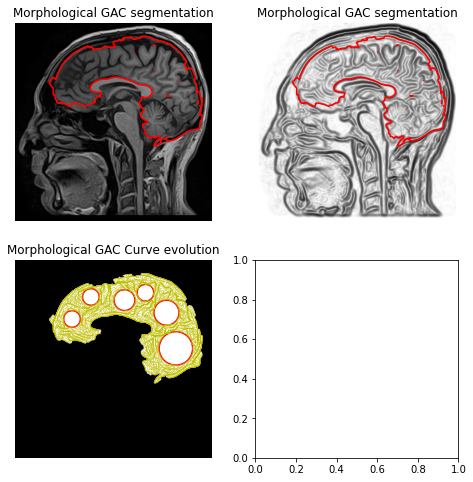

In [ ]:


# img_to_seg = img_cell ; r0 = 130;  c0 = 125 ; R0 = 30  # inflate
# img_to_seg = img_cell ; r0 = 130;  c0 = 125 ; R0 = 70  # deflate
img_to_seg = img_MRIb ; r0 = 220 ; c0 = 700 ; R0 = 100  # for spine and inflate

SMOOTHING    = 0; Niter_smooth = 3
INV_EDGE_MAP = 1; # needed when using the Balloon force

img_ori    = img_to_seg

# Hyper parameters for snake and balloon
Thresh_cont_val  = 'auto' ; Balloon_weight   = 1.1 ; Smooth_cont_iter = 1 ;
Niter_snake      = 100

# smoothing
if SMOOTHING:
    img_to_seg = gaussian(img_to_seg, Niter_smooth, preserve_range=False)

# Test segment directly on edge image [QUESTION: WHY IS THE RESULT DIFFERENT?]
if INV_EDGE_MAP:
    img_to_seg = skimage.segmentation.inverse_gaussian_gradient(img_to_seg) # Compute the magnitude of the gradients in the image and then inverts the result in the range [0, 1]

#Print threshold used by "auto"
print(np.percentile(img_to_seg, 40))


# initialise call back
evolution = []
callback = store_evolution_in(evolution)

# Initialise contour

disk1 = skimage.segmentation.disk_level_set(img_to_seg.shape, center=[280,270], radius=40)
disk2 = skimage.segmentation.disk_level_set(img_to_seg.shape, center=[190,520], radius=50)
disk3 = skimage.segmentation.disk_level_set(img_to_seg.shape, center=[250,720], radius=60)
disk4 = skimage.segmentation.disk_level_set(img_to_seg.shape, center=[420,765], radius=80)

disk5 = skimage.segmentation.disk_level_set(img_to_seg.shape, center=[175,360], radius=40)
disk6 = skimage.segmentation.disk_level_set(img_to_seg.shape, center=[155,620], radius=40)


init_ls = disk1 + disk2 + disk3 + disk4 + disk5 + disk6

# Run geodesic active contour
ls       = morphological_geodesic_active_contour(
            img_to_seg, Niter_snake, init_ls,
            smoothing=Smooth_cont_iter, balloon=Balloon_weight,
            threshold=Thresh_cont_val,
            iter_callback=callback);


fig, axes = plt.subplots(2, 2, figsize=(8, 8));
ax = axes.flatten();

ax[0].imshow(img_ori, cmap="gray");
ax[0].set_axis_off();
ax[0].contour(ls, [0.5], colors='r');
ax[0].set_title("Morphological GAC segmentation", fontsize=12);

ax[1].imshow(img_to_seg, cmap="gray");
ax[1].set_axis_off();
ax[1].contour(ls, [0.5], colors='r');
ax[1].set_title("Morphological GAC segmentation", fontsize=12);

ax[2].imshow(ls, cmap="gray");
ax[2].set_axis_off();
contour = ax[2].contour(evolution[0], [0.5], colors='r');
contour.collections[0].set_label("Contours");
title = f'Morphological GAC Curve evolution';
ax[2].set_title(title, fontsize=12);
for i in range(1, Niter_snake-1, 5):
  contour = ax[2].contour(evolution[i], [0.01], linewidths=0.5, colors='y');
plt.show();